In [ ]:
!apt-get install -y unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:

from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
!unzip -q "/content/MMAFEDB_15K-20250827T102051Z-1-001.zip" -d /content/

In [ ]:
# === Import Library ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import mixed_precision

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# === Aktifkan Mixed Precision (lebih cepat di GPU modern: L4 / A100) ===
mixed_precision.set_global_policy("mixed_float16")

EfficientNetB0 tetap termasuk CNN modern karena dibangun dari lapisan Conv2D + Pooling (dalam bentuk blok MBConv hasil neural architecture search). Ia berfungsi sebagai feature extractor, lalu hasilnya diringkas dengan GlobalAveragePooling2D dan dikirim ke Dense layer untuk klasifikasi. Jadi meski tidak ditulis manual, di dalamnya ada banyak lapisan convolutional.

Singkatnya: EfficientNetB0 = deep CNN pretrained (transfer learning).

# CNN

✅ GPU detected: Tesla T4
Using batch_size = 64
✅ Mixed Precision enabled
Found 19606 images belonging to 4 classes.
Found 3503 images belonging to 4 classes.
Found 3511 images belonging to 4 classes.
Class labels: ['angry', 'fear', 'happy', 'sad']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,076 (1.87 MB)

 Trainable params: 489,348 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

🚀 Training started...
Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.3383 - loss: 1.7165 - val_accuracy: 0.5709 - val_loss: 1.1223
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 62s 201ms/step - accuracy: 0.4447 - loss: 1.3305 - val_accuracy: 0.5655 - val_loss: 1.0554
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 62s 202ms/step - accuracy: 0.4936 - loss: 1.2035 - val_accuracy: 0.5824 - val_loss: 1.0485
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 80s 197ms/step - accuracy: 0.5227 - loss: 1.1472 - val_accuracy: 0.5826 - val_loss: 1.1556
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.5374 - loss: 1.0898 - val_accuracy: 0.4944 - val_loss: 1.0812
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.5432 - loss: 1.0626 - val_accuracy: 0.5669 - val_loss: 1.0255
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.5573 - loss: 1.0293 - val_accuracy: 0.5373 - val_loss: 1.0547
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 59s 193ms/step - accu

✅ Training Selesai!
Saved artifact at 'final_cnn_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_690')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139087152033680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152035792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152033872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152037520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152036176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152034640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152037712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152036752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152035024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139087152036560: TensorSpec(shape=(), dtype=tf.resource, nam

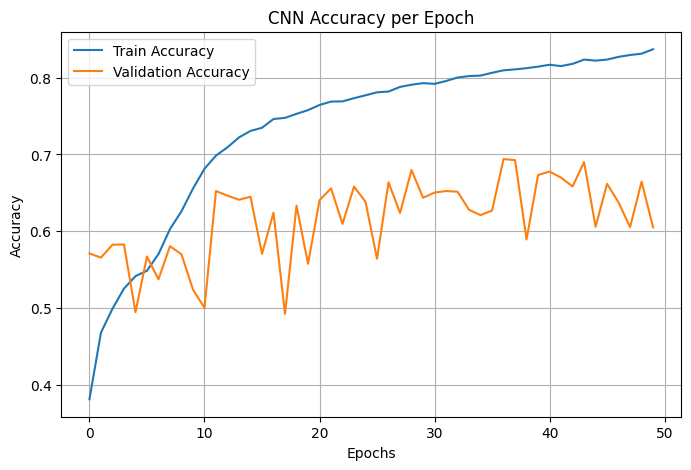

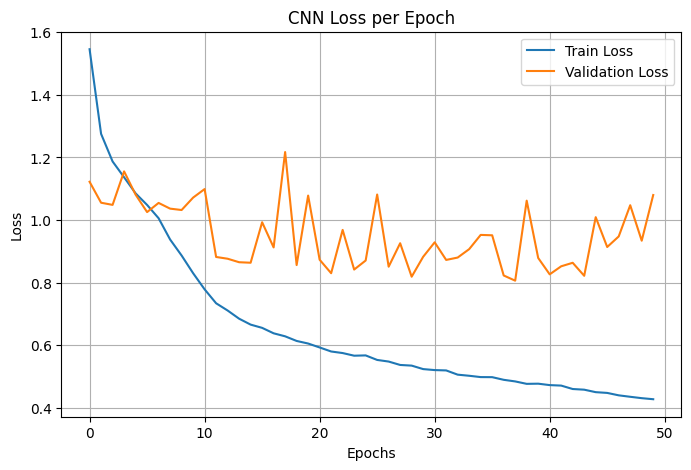

307/307 ━━━━━━━━━━━━━━━━━━━━ 58s 189ms/step - accuracy: 0.8270 - loss: 0.4395
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6063 - loss: 1.0968
 3/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7474 - loss: 0.7829

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6493 - loss: 0.9285

📊 Hasil Evaluasi:
Train Acc: 0.8279, Train Loss: 0.4386
Val Acc:   0.6049, Val Loss:   1.0800
Test Acc:  0.6659, Test Loss:  0.8967


In [ ]:
# === Final Training Pipeline CNN for Colab ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# === 1. GPU Detection ===
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    gpu_name = tf.config.experimental.get_device_details(gpus[0]).get("device_name", "Unknown GPU")
    print("✅ GPU detected:", gpu_name)

    # Pilih batch_size sesuai GPU
    if "A100" in gpu_name or "V100" in gpu_name:
        batch_size = 64
    elif "L4" in gpu_name or "T4" in gpu_name:
        batch_size = 64
    else:
        batch_size = 16
else:
    print("⚠️ No GPU detected, fallback to CPU. Training will be slow.")
    batch_size = 8

print(f"Using batch_size = {batch_size}")

# === 2. Mixed Precision (jika GPU mendukung) ===
try:
    mixed_precision.set_global_policy("mixed_float16")
    print("✅ Mixed Precision enabled")
except:
    print("⚠️ Mixed Precision not supported, running in float32")

# === 3. Dataset Paths ===
img_size = (96, 96)
train_dir = "/content/MMAFEDB_15K/train"
val_dir = "/content/MMAFEDB_15K/valid"
test_dir = "/content/MMAFEDB_15K/test"

# === 4. Data Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.7,1.3],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

class_labels = list(test_gen.class_indices.keys())
print("Class labels:", class_labels)

# === 5. Callbacks ===
#early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# === 6. Model Architecture ===
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(class_labels), activation='softmax', dtype="float32")  # Output sesuai jumlah kelas
])

opt = Adam(learning_rate=3e-4)
cnn_model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# === 7. Training ===
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

print("🚀 Training started...")
cnn_history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    #callbacks=[early_stop, reduce_lr],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

print("✅ Training Selesai!")

# === 8. Simpan Final Model ===
# Simpan ke format HDF5 (legacy, masih banyak dipakai)
cnn_model.save("final_cnn_model.h5")

# Simpan ke format baru Keras
cnn_model.save("final_cnn_model.keras")

# Simpan ke format TensorFlow SavedModel (untuk TFServing / TFLite)
cnn_model.export("final_cnn_model_tf")

print("📁 Model tersimpan sebagai:")
print("- final_cnn_model.h5")
print("- final_cnn_model.keras")
print("- final_cnn_model_tf/ (SavedModel format)")

# === 9. Plot Grafik Accuracy & Loss ===
import matplotlib.pyplot as plt

history = cnn_history.history

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('CNN Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# === 10. Evaluasi Train / Val / Test ===
train_loss, train_acc = cnn_model.evaluate(train_gen, verbose=1)
val_loss, val_acc     = cnn_model.evaluate(val_gen, verbose=1)
test_loss, test_acc   = cnn_model.evaluate(test_gen, verbose=1)

print("\n📊 Hasil Evaluasi:")
print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Val Acc:   {val_acc:.4f}, Val Loss:   {val_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}, Test Loss:  {test_loss:.4f}")


In [ ]:
cnn_model.export("final_cnn_model")  # Ini akan membuat folder SavedModel

Saved artifact at 'final_cnn_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139659795517264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703371088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703372432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703372816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703369360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703372048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703371472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703371664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703373776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703373968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139656703373200: 

Found 3511 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step


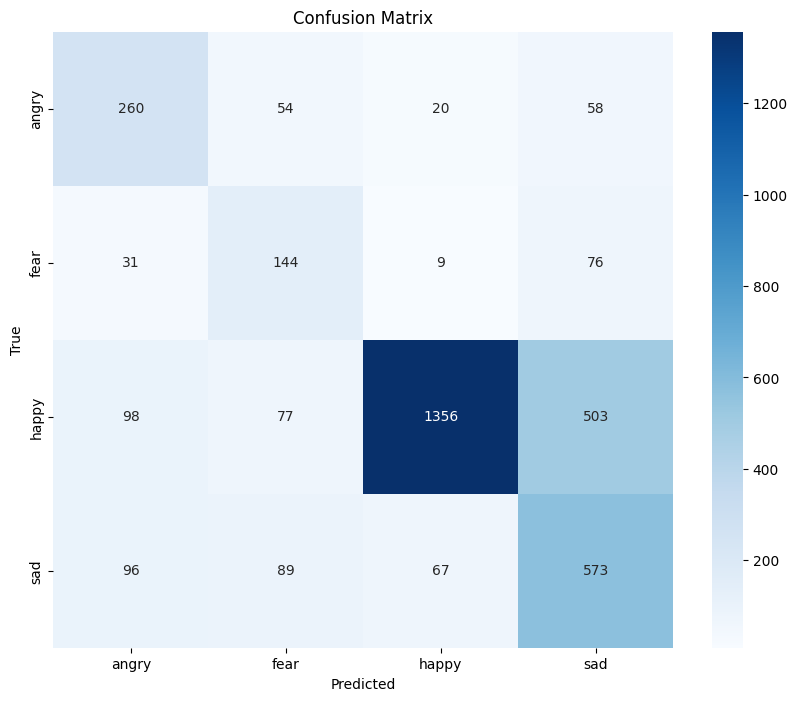

              precision    recall  f1-score   support

       angry       0.54      0.66      0.59       392
        fear       0.40      0.55      0.46       260
       happy       0.93      0.67      0.78      2034
         sad       0.47      0.69      0.56       825

    accuracy                           0.66      3511
   macro avg       0.58      0.64      0.60      3511
weighted avg       0.74      0.66      0.68      3511



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === 1. Load Model ===
model = tf.keras.models.load_model("/content/final_cnn_model.h5")

# === 2. Ambil data test generator ===
# Pastikan definisi test_gen sama seperti saat training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (96,96)
test_dir = "/content/MMAFEDB_15K/test"
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# === 3. Prediksi ===
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# === 4. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# === 5. Classification Report (opsional) ===
print(classification_report(y_true, y_pred, target_names=class_labels))


Saving 9-not-need-happy.jpg to 9-not-need-happy (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step

=== Hasil Probabilitas ===
 angry: 0.20
  fear: 0.05
 happy: 0.46
   sad: 0.29

Prediksi utama: happy
Confidence: 0.46


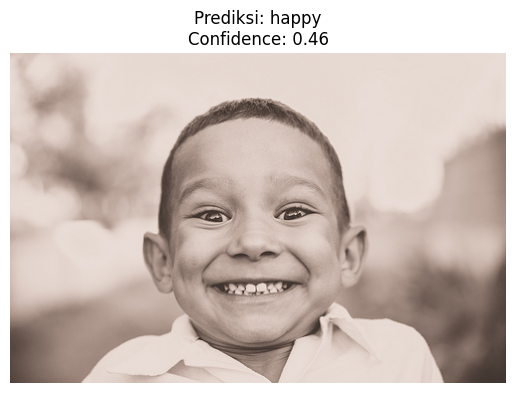

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load model kamu
model = tf.keras.models.load_model("/content/final_cnn_model.h5")

# Daftar label sesuai urutan training
class_labels = ["angry", "fear", "happy", "sad"]

def predict_emotion_verbose(model, img_path, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)[0]

    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = np.max(prediction)

    # Print semua kelas
    print("\n=== Hasil Probabilitas ===")
    for label, prob in zip(class_labels, prediction):
        print(f"{label:>6}: {prob:.2f}")

    print("\nPrediksi utama:", predicted_class)
    print("Confidence:", f"{confidence:.2f}")

    # # Top-3 prediksi
    # top3_idx = prediction.argsort()[-3:][::-1]
    # print("\n--- Top-3 Prediksi ---")
    # for i in top3_idx:
    #     print(f"{class_labels[i]:>6}: {prediction[i]:.2f}")

    # Plot gambar
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# --- Upload gambar dari komputer ---
uploaded = files.upload()

for fn in uploaded.keys():
    predict_emotion_verbose(model, fn, class_labels)


# MobilenetV2

✅ Mixed Precision enabled
Found 19606 images belonging to 4 classes.
Found 3503 images belonging to 4 classes.
Class Weights: {0: np.float64(2.0063446582071225), 1: np.float64(2.688699945145365), 2: np.float64(0.4561656584457887), 3: np.float64(1.0667029379760609)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
🚀 Stage 1: Training top classifier (base frozen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.3074 - loss: 1.4917
Epoch 1: val_accuracy improved from -inf to 0.24379, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.3076 - loss: 1.4914 - val_accuracy: 0.2438 - val_loss: 1.4040
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.4145 - loss: 1.3368
Epoch 2: val_accuracy improved from 0.24379 to 0.33543, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 258s 838ms/step - accuracy: 0.4145 - loss: 1.3368 - val_accuracy: 0.3354 - val_loss: 1.3277
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.4414 - loss: 1.3052
Epoch 3: val_accuracy improved from 0.33543 to 0.37739, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 844ms/step - accuracy: 0.4414 - loss: 1.3052 - val_accuracy: 0.3774 - val_loss: 1.3086
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.4445 - loss: 1.2922
Epoch 4: val_accuracy did not improve from 0.37739
307/307 ━━━━━━━━━━━━━━━━━━━━ 260s 845ms/step - accuracy: 0.4445 - loss: 1.2922 - val_accuracy: 0.3243 - val_loss: 1.3497
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.4476 - loss: 1.2928
Epoch 5: val_accuracy did not improve from 0.37739
307/307 ━━━━━━━━━━━━━━━━━━━━ 258s 840ms/step - accuracy: 0.4476 - loss: 1.2928 - val_accuracy: 0.3237 - val_loss: 1.3631
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.4637 - loss: 1.2960
Epoch 6: val_accuracy improved from 0.37739 to 0.42164, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 257s 837ms/step - accuracy: 0.4637 - loss: 1.2959 - val_accuracy: 0.4216 - val_loss: 1.3011
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.4608 - loss: 1.2848
Epoch 7: val_accuracy did not improve from 0.42164
307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 842ms/step - accuracy: 0.4608 - loss: 1.2848 - val_accuracy: 0.3640 - val_loss: 1.3263
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.4607 - loss: 1.2826
Epoch 8: val_accuracy did not improve from 0.42164
307/307 ━━━━━━━━━━━━━━━━━━━━ 256s 835ms/step - accuracy: 0.4607 - loss: 1.2825 - val_accuracy: 0.3346 - val_loss: 1.3308
Epoch 9/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.4740 - loss: 1.2805
Epoch 9: val_accuracy did not improve from 0.42164
307/307 ━━━━━━━━━━━━━━━━━━━━ 256s 834ms/step - accuracy: 0.4740 - loss: 1.2804 - val_accuracy: 0.3683 - val_loss: 1.3242
Epoch 10/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.4800 - loss: 1.2630
Epoch 10: 

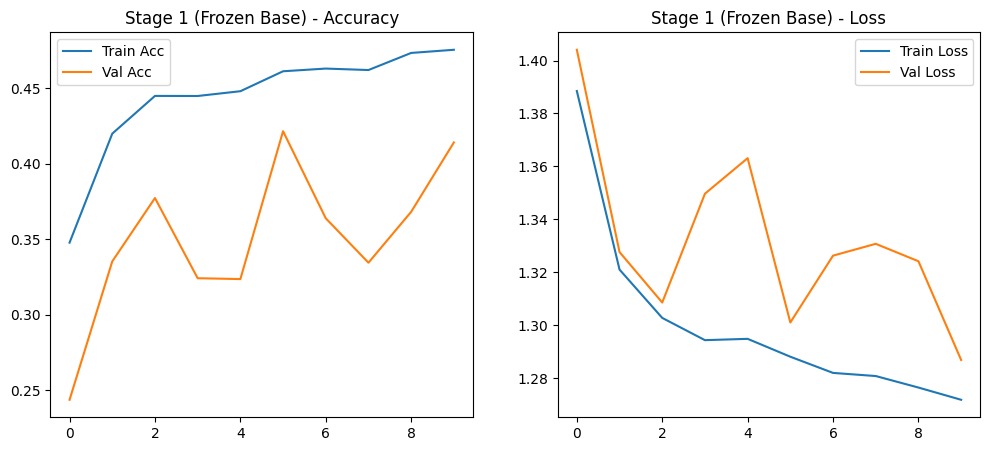

🚀 Stage 2: Fine-tuning last 50 layers
Epoch 1/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.4667 - loss: 1.2661
Epoch 1: val_accuracy improved from 0.42164 to 0.57922, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.4669 - loss: 1.2660 - val_accuracy: 0.5792 - val_loss: 1.2267
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.6060 - loss: 1.1629
Epoch 2: val_accuracy improved from 0.57922 to 0.59492, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 256s 832ms/step - accuracy: 0.6061 - loss: 1.1628 - val_accuracy: 0.5949 - val_loss: 1.1540
Epoch 3/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.6504 - loss: 1.1195
Epoch 3: val_accuracy improved from 0.59492 to 0.60491, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 258s 842ms/step - accuracy: 0.6505 - loss: 1.1195 - val_accuracy: 0.6049 - val_loss: 1.1439
Epoch 4/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6822 - loss: 1.0632
Epoch 4: val_accuracy improved from 0.60491 to 0.62518, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 844ms/step - accuracy: 0.6822 - loss: 1.0632 - val_accuracy: 0.6252 - val_loss: 1.0861
Epoch 5/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7027 - loss: 1.0364
Epoch 5: val_accuracy improved from 0.62518 to 0.62746, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 255s 829ms/step - accuracy: 0.7027 - loss: 1.0364 - val_accuracy: 0.6275 - val_loss: 1.0584
Epoch 6/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7051 - loss: 1.0412
Epoch 6: val_accuracy improved from 0.62746 to 0.64716, saving model to mobilenet_best.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 255s 830ms/step - accuracy: 0.7051 - loss: 1.0412 - val_accuracy: 0.6472 - val_loss: 1.0166
Epoch 7/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7197 - loss: 1.0200
Epoch 7: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 258s 839ms/step - accuracy: 0.7197 - loss: 1.0199 - val_accuracy: 0.6272 - val_loss: 1.0225
Epoch 8/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.7232 - loss: 1.0030
Epoch 8: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 844ms/step - accuracy: 0.7232 - loss: 1.0029 - val_accuracy: 0.5929 - val_loss: 1.0876
Epoch 9/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.7334 - loss: 0.9832
Epoch 9: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 257s 837ms/step - accuracy: 0.7334 - loss: 0.9832 - val_accuracy: 0.5738 - val_loss: 1.1081
Epoch 10/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.7343 - loss: 0.9830
Epoch 10: 

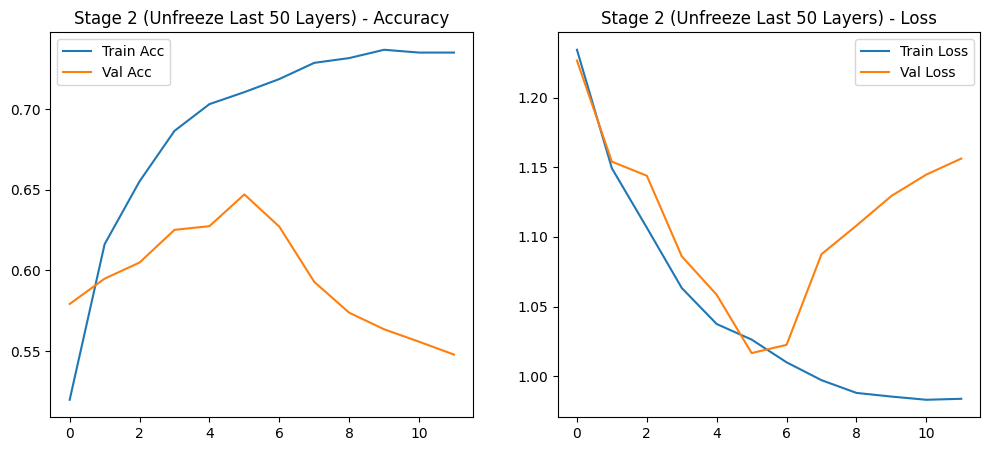

🚀 Stage 3: Full fine-tuning
Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6574 - loss: 1.0930
Epoch 1: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.6574 - loss: 1.0930 - val_accuracy: 0.5495 - val_loss: 1.1486
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6981 - loss: 1.0287
Epoch 2: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 270s 881ms/step - accuracy: 0.6981 - loss: 1.0287 - val_accuracy: 0.5327 - val_loss: 1.1873
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7142 - loss: 1.0075
Epoch 3: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 267s 871ms/step - accuracy: 0.7142 - loss: 1.0075 - val_accuracy: 0.5704 - val_loss: 1.1335
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.7146 - loss: 1.0034
Epoch 4: val_accuracy did not improve from 0.64716
307/307 ━━━━━━━━━━━━━━━━━━━━ 266s 868ms/step - accuracy: 0.

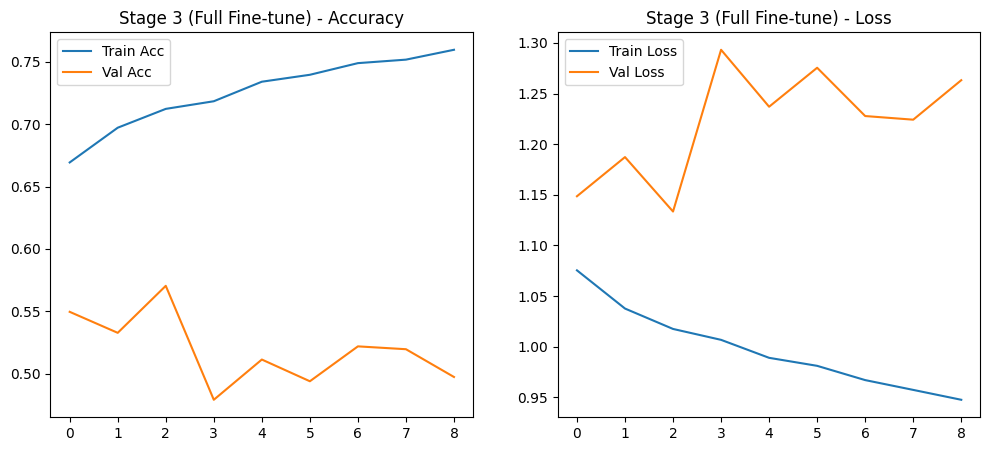

✅ Training selesai! Model terbaik tersimpan di mobilenet_best.h5


In [ ]:
# === MobileNetV2 Transfer Learning + Fine-tuning (Revisi) ===
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# === 1. Setup GPU & Mixed Precision ===
gpus = tf.config.list_physical_devices("GPU")
batch_size = 64 if gpus else 8
try:
    mixed_precision.set_global_policy("mixed_float16")
    print("✅ Mixed Precision enabled")
except:
    print("⚠️ Mixed Precision not supported")

# === 2. Dataset ===
img_size = (224, 224)
train_dir = "/content/MMAFEDB_15K/train"
val_dir = "/content/MMAFEDB_15K/valid"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

num_classes = len(train_gen.class_indices)

# === Class Weights ===
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# === 3. Base Model ===
base_mobile = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_mobile.trainable = False  # Stage 1: freeze all

# === 4. Build Model (Revisi: deeper classifier) ===
def build_model(base):
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    return model

model = build_model(base_mobile)

# === 5. Callbacks ===
early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("mobilenet_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# === Helper plotting function ===
def plot_history(history, stage_name):
    plt.figure(figsize=(12,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{stage_name} - Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{stage_name} - Loss')
    plt.legend()
    plt.show()

# === 6. Training Pipeline ===

## Stage 1: Freeze base
print("🚀 Stage 1: Training top classifier (base frozen)")
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15)
model.compile(optimizer=Adam(1e-3), loss=loss_fn, metrics=['accuracy'])
hist1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)
plot_history(hist1, "Stage 1 (Frozen Base)")

## Stage 2: Unfreeze last 50 layers
print("🚀 Stage 2: Fine-tuning last 50 layers")
base_mobile.trainable = True
for layer in base_mobile.layers[:-50]:
    layer.trainable = False

steps_per_epoch = len(train_gen)
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=steps_per_epoch*10,
    alpha=1e-6
)

model.compile(optimizer=Adam(cosine_decay), loss=loss_fn, metrics=['accuracy'])
hist2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)
plot_history(hist2, "Stage 2 (Unfreeze Last 50 Layers)")

## Stage 3: Full fine-tuning (revisi: LR lebih besar)
print("🚀 Stage 3: Full fine-tuning")
for layer in base_mobile.layers:
    layer.trainable = True

cosine_decay_full = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=steps_per_epoch*20,
    alpha=1e-7
)

model.compile(optimizer=Adam(cosine_decay_full), loss=loss_fn, metrics=['accuracy'])
hist3 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)
plot_history(hist3, "Stage 3 (Full Fine-tune)")

print("✅ Training selesai! Model terbaik tersimpan di mobilenet_best.h5")


🚀 Stage 4 (Revisi): Lanjutan training dari mobilenet_best.h5


Found 19606 images belonging to 4 classes.
Found 3503 images belonging to 4 classes.
Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6766 - loss: 0.8769
Epoch 1: val_accuracy improved from -inf to 0.59149, saving model to mobilenet_best_stage4.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 136s 328ms/step - accuracy: 0.6767 - loss: 0.8769 - val_accuracy: 0.5915 - val_loss: 1.0105
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7118 - loss: 0.8095
Epoch 2: val_accuracy did not improve from 0.59149
307/307 ━━━━━━━━━━━━━━━━━━━━ 53s 172ms/step - accuracy: 0.7118 - loss: 0.8095 - val_accuracy: 0.5781 - val_loss: 1.0591
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7159 - loss: 0.7851
Epoch 3: val_accuracy improved from 0.59149 to 0.64174, saving model to mobilenet_best_stage4.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 53s 173ms/step - accuracy: 0.7159 - loss: 0.7851 - val_accuracy: 0.6417 - val_loss: 0.9257
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s

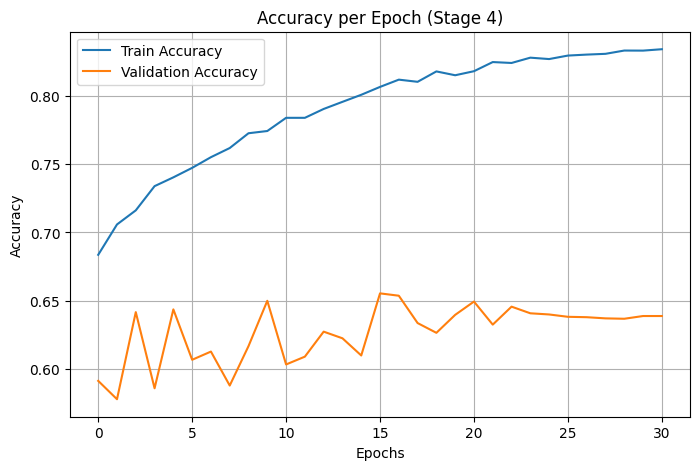

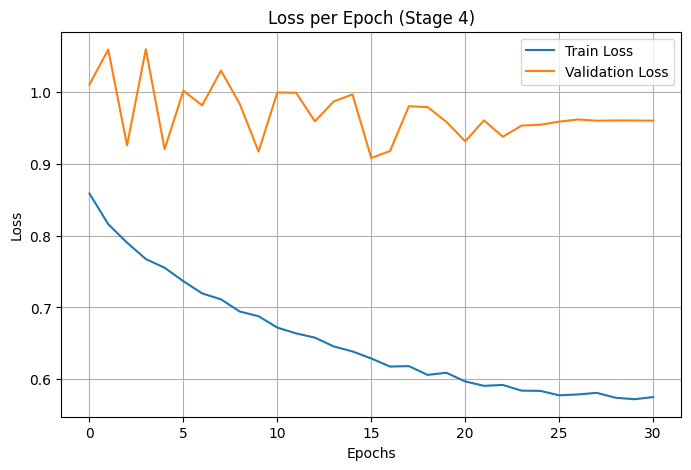

In [ ]:
# === Stage 4: Lanjutan training dari model tersimpan (versi revisi) ===
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

print("🚀 Stage 4 (Revisi): Lanjutan training dari mobilenet_best.h5")

# Load model terbaik yang sudah tersimpan
model = load_model("/content/mobilenet_best.h5")

# Pastikan semua layer bisa dilatih
for layer in model.layers:
    layer.trainable = True

# 🔥 Augmentasi lebih realistis
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
])

# Dataset ulang
img_size = (224, 224)
batch_size = 64

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen   = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    "/content/MMAFEDB_15K/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    "/content/MMAFEDB_15K/valid",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Bungkus generator dengan augmentasi keras
def augmented_gen(gen):
    for x, y in gen:
        yield data_augmentation(x), y

aug_train_gen = augmented_gen(train_gen)

# 🔧 Scheduler learning rate lebih tinggi
steps_per_epoch = len(train_gen)
cosine_decay_extra = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=steps_per_epoch * 30,
    alpha=1e-6
)

# Compile ulang model
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=Adam(cosine_decay_extra),
              loss=loss_fn,
              metrics=['accuracy'])

# Callback
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
checkpoint_extra = ModelCheckpoint(
    "mobilenet_best_stage4.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Training lanjutan
hist4 = model.fit(
    aug_train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=len(train_gen),
    callbacks=[early_stop, checkpoint_extra]
)

print("✅ Stage 4 selesai! Model tersimpan di mobilenet_best_stage4.keras")

# === Plot Grafik Accuracy & Loss ===
history = hist4.history

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch (Stage 4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch (Stage 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 3511 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 562ms/step


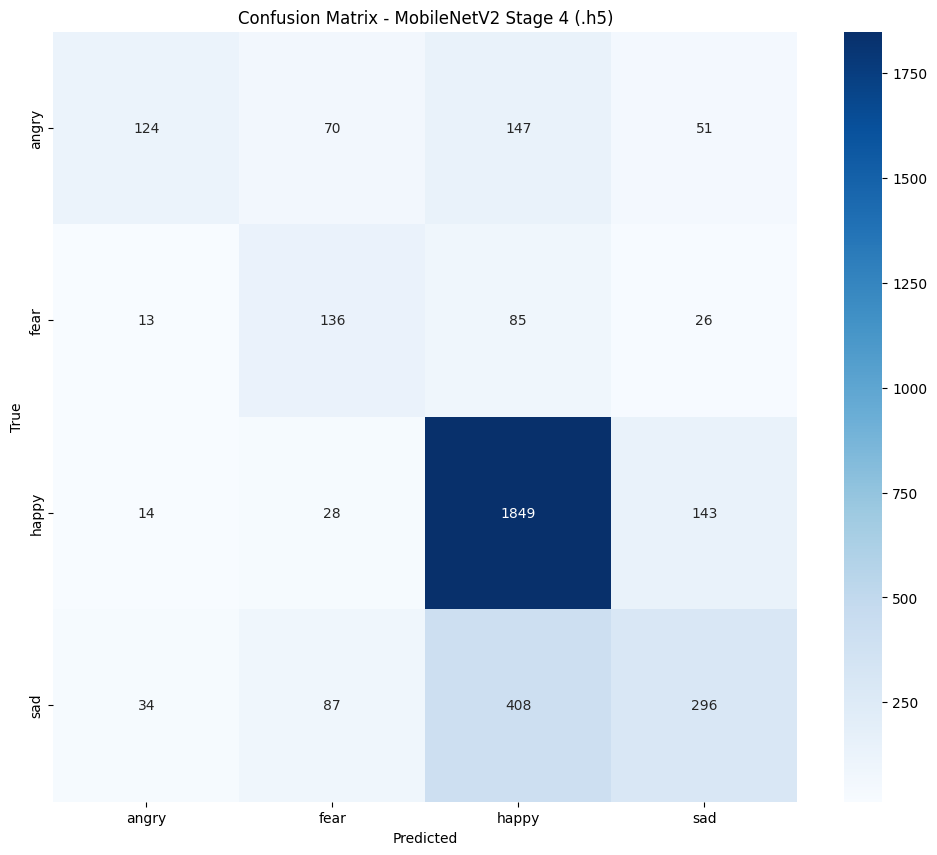

              precision    recall  f1-score   support

       angry       0.67      0.32      0.43       392
        fear       0.42      0.52      0.47       260
       happy       0.74      0.91      0.82      2034
         sad       0.57      0.36      0.44       825

    accuracy                           0.68      3511
   macro avg       0.60      0.53      0.54      3511
weighted avg       0.67      0.68      0.66      3511



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# === 1. Load model dari .h5 ===
model = tf.keras.models.load_model("/content/mobilenet_best_stage4.h5")

# === 2. Data test generator ===
img_size = (224,224)
batch_size = 64
test_dir = "/content/MMAFEDB_15K/test"

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(test_gen.class_indices.keys())

# === 3. Prediksi ===
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_gen.classes

# === 4. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MobileNetV2 Stage 4 (.h5)")
plt.show()

# === 5. Classification Report ===
print(classification_report(y_true, y_pred, target_names=class_labels))


Saving sad.jpg to sad.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

=== Hasil Probabilitas ===
 angry: 0.13
  fear: 0.09
 happy: 0.15
   sad: 0.63

Prediksi utama: sad
Confidence: 0.63


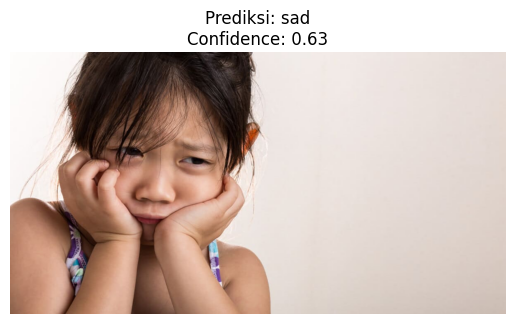

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Upload file gambar
uploaded = files.upload()

# Load model
model = tf.keras.models.load_model("/content/mobilenet_best (3).h5")

# Daftar label sesuai urutan training (isi sesuai dataset kamu)
class_labels = ["angry", "fear", "happy", "sad"]

def predict_emotion_verbose(model, img_path, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)[0]

    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = np.max(prediction)

    # Print semua kelas
    print("\n=== Hasil Probabilitas ===")
    for label, prob in zip(class_labels, prediction):
        print(f"{label:>6}: {prob:.2f}")

    print("\nPrediksi utama:", predicted_class)
    print("Confidence:", f"{confidence:.2f}")

    # # Top-3 prediksi
    # top3_idx = prediction.argsort()[-3:][::-1]
    # print("\n--- Top-3 Prediksi ---")
    # for i in top3_idx:
    #     print(f"{class_labels[i]:>6}: {prediction[i]:.2f}")

    # Plot gambar dengan hasil
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Jalankan prediksi untuk semua file upload
for fn in uploaded.keys():
    predict_emotion_verbose(model, fn, class_labels)


# VGG16

✅ Mixed Precision enabled
Found 19606 images belonging to 4 classes.
Found 3503 images belonging to 4 classes.
Found 3511 images belonging to 4 classes.
Class Weights: {0: np.float64(2.0063446582071225), 1: np.float64(2.688699945145365), 2: np.float64(0.4561656584457887), 3: np.float64(1.0667029379760609)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🚀 Stage 1: Training top classifier (base frozen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.3174 - loss: 1.4673
Epoch 1: val_accuracy improved from -inf to 0.42364, saving model to mobilenet_best.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.3175 - loss: 1.4671 - val_accuracy: 0.4236 - val_loss: 1.3080
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.4073 - loss: 1.3368
Epoch 2: val_accuracy did not improve from 0.42364
307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 842ms/step - accuracy: 0.4074 - loss: 1.3367 - val_accuracy: 0.4191 - val_loss: 1.3156
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4420 - loss: 1.3207
Epoch 3: val_accuracy did not improve from 0.42364
307/307 ━━━━━━━━━━━━━━━━━━━━ 260s 847ms/step - accuracy: 0.4420 - loss: 1.3207 - val_accuracy: 0.3731 - val_loss: 1.3222
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.4489 - loss: 1.2853
Epoch 4: val_accuracy did not improve from 0.42364
307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 844ms/step 

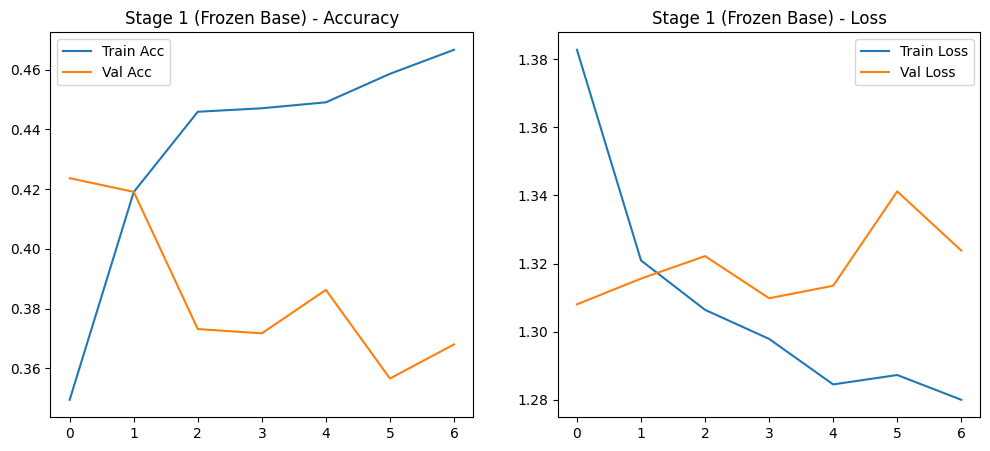

🚀 Stage 2: Fine-tuning last 50 layers
Epoch 1/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.4349 - loss: 1.2985
Epoch 1: val_accuracy improved from 0.42364 to 0.56666, saving model to mobilenet_best.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.4351 - loss: 1.2984 - val_accuracy: 0.5667 - val_loss: 1.1464
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.5851 - loss: 1.1807
Epoch 2: val_accuracy improved from 0.56666 to 0.59064, saving model to mobilenet_best.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 260s 846ms/step - accuracy: 0.5852 - loss: 1.1806 - val_accuracy: 0.5906 - val_loss: 1.2632
Epoch 3/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.6433 - loss: 1.1185
Epoch 3: val_accuracy did not improve from 0.59064
307/307 ━━━━━━━━━━━━━━━━━━━━ 264s 861ms/step - accuracy: 0.6433 - loss: 1.1185 - val_accuracy: 0.5758 - val_loss: 1.1213
Epoch 4/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6758 - loss: 1.0743
Epoch 4: val_

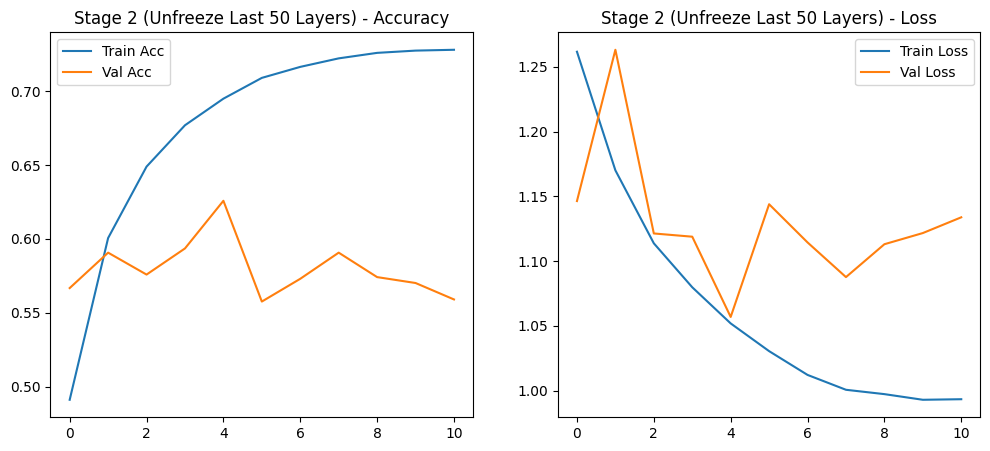

🚀 Stage 3: Full fine-tuning
Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6494 - loss: 1.1173
Epoch 1: val_accuracy did not improve from 0.62575
307/307 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.6494 - loss: 1.1172 - val_accuracy: 0.6123 - val_loss: 1.0824
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6868 - loss: 1.0507
Epoch 2: val_accuracy did not improve from 0.62575
307/307 ━━━━━━━━━━━━━━━━━━━━ 270s 879ms/step - accuracy: 0.6868 - loss: 1.0506 - val_accuracy: 0.5492 - val_loss: 1.1821
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.6998 - loss: 1.0320
Epoch 3: val_accuracy did not improve from 0.62575
307/307 ━━━━━━━━━━━━━━━━━━━━ 269s 876ms/step - accuracy: 0.6998 - loss: 1.0320 - val_accuracy: 0.5687 - val_loss: 1.1420
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7079 - loss: 1.0239
Epoch 4: val_accuracy did not improve from 0.62575
307/307 ━━━━━━━━━━━━━━━━━━━━ 269s 876ms/step - accuracy: 0.

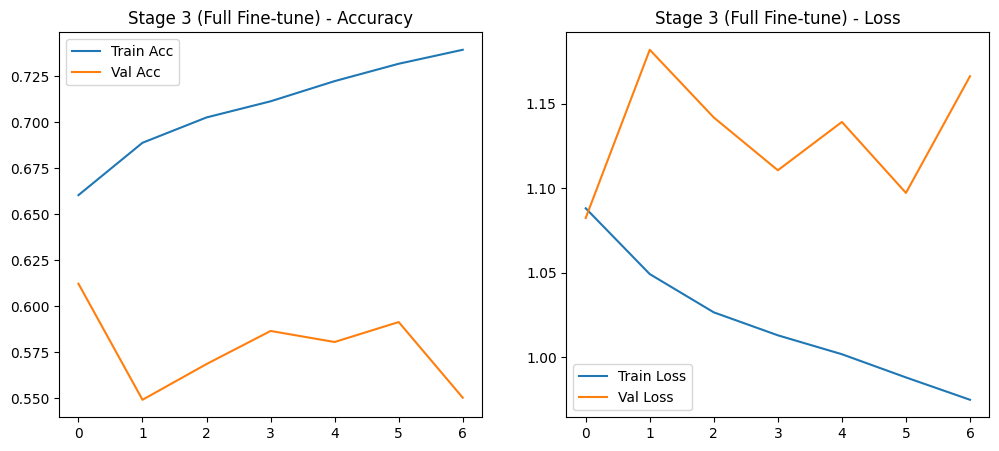

✅ Training selesai! Model terbaik tersimpan di mobilenet_best.keras

📊 Evaluasi Model Terbaik (Load dari checkpoint)
307/307 ━━━━━━━━━━━━━━━━━━━━ 278s 865ms/step - accuracy: 0.6948 - loss: 0.9360
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.6458 - loss: 1.0346
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.6929 - loss: 0.9841

Train Acc: 0.7000, Train Loss: 0.9304
Val   Acc: 0.6257, Val   Loss: 1.0569
Test  Acc: 0.6690, Test  Loss: 0.9921


In [ ]:
# === MobileNetV2 Transfer Learning + Fine-tuning (Final Pipeline) ===
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# === 1. Setup GPU & Mixed Precision ===
gpus = tf.config.list_physical_devices("GPU")
batch_size = 64 if gpus else 8
try:
    mixed_precision.set_global_policy("mixed_float16")
    print("✅ Mixed Precision enabled")
except:
    print("⚠️ Mixed Precision not supported")

# === 2. Dataset ===
img_size = (224, 224)
train_dir = "/content/MMAFEDB_15K/train"
val_dir   = "/content/MMAFEDB_15K/valid"
test_dir  = "/content/MMAFEDB_15K/test"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
val_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size,
                                              batch_size=batch_size, class_mode='categorical')
val_gen   = val_datagen.flow_from_directory(val_dir, target_size=img_size,
                                            batch_size=batch_size, class_mode='categorical')
test_gen  = test_datagen.flow_from_directory(test_dir, target_size=img_size,
                                             batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(train_gen.class_indices)

# === 3. Class Weights ===
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# === 4. Base Model ===
base_mobile = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_mobile.trainable = False  # Stage 1: freeze all

# === 5. Build Model ===
def build_model(base):
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    return model

model = build_model(base_mobile)

# === 6. Callbacks ===
early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("mobilenet_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

# === 7. Helper plotting function ===
def plot_history(history, stage_name):
    plt.figure(figsize=(12,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{stage_name} - Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{stage_name} - Loss')
    plt.legend()
    plt.show()

# === 8. Training Pipeline ===
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15)

## Stage 1: Freeze base
print("🚀 Stage 1: Training top classifier (base frozen)")
model.compile(optimizer=Adam(1e-3), loss=loss_fn, metrics=['accuracy'])
hist1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)
plot_history(hist1, "Stage 1 (Frozen Base)")

## Stage 2: Unfreeze last 50 layers
print("🚀 Stage 2: Fine-tuning last 50 layers")
base_mobile.trainable = True
for layer in base_mobile.layers[:-50]:
    layer.trainable = False

steps_per_epoch = len(train_gen)
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=steps_per_epoch*10,
    alpha=1e-6
)

model.compile(optimizer=Adam(cosine_decay), loss=loss_fn, metrics=['accuracy'])
hist2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)
plot_history(hist2, "Stage 2 (Unfreeze Last 50 Layers)")

## Stage 3: Full fine-tuning
print("🚀 Stage 3: Full fine-tuning")
for layer in base_mobile.layers:
    layer.trainable = True

cosine_decay_full = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=steps_per_epoch*20,
    alpha=1e-7
)

model.compile(optimizer=Adam(cosine_decay_full), loss=loss_fn, metrics=['accuracy'])
hist3 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)
plot_history(hist3, "Stage 3 (Full Fine-tune)")

print("✅ Training selesai! Model terbaik tersimpan di mobilenet_best.keras")

# === 9. Evaluasi Akhir ===
print("\n📊 Evaluasi Model Terbaik (Load dari checkpoint)")
best_model = tf.keras.models.load_model("mobilenet_best.keras")

train_loss, train_acc = best_model.evaluate(train_gen, verbose=1)
val_loss, val_acc     = best_model.evaluate(val_gen, verbose=1)
test_loss, test_acc   = best_model.evaluate(test_gen, verbose=1)

print(f"\nTrain Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Val   Acc: {val_acc:.4f}, Val   Loss: {val_loss:.4f}")
print(f"Test  Acc: {test_acc:.4f}, Test  Loss: {test_loss:.4f}")


Found 19606 images belonging to 4 classes.
Found 3503 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🚀 Stage 3: Full Fine-tuning with WarmupCosineDecay
Epoch 1/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7149 - loss: 0.8959
Epoch 1: val_accuracy improved from -inf to 0.63403, saving model to /content/vgg16_stage3_full_best.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.7149 - loss: 0.8959 - val_accuracy: 0.6340 - val_loss: 1.0580
Epoch 2/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7373 - loss: 0.8556
Epoch 2: val_accuracy did not improve from 0.63403
307/307 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.7373 - loss: 0.8556 - val_accuracy: 0.3811 - val_loss: 1.9603
Epoch 3/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7498 - loss: 0.8301
Epoch 3: val_accuracy improved from 0.63403 to 0.66886, saving model to /content/vgg16_stage3_full_best.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.7498 - loss: 0.8301 - val_accuracy: 0.6689 - val_loss: 0.9899
Epoch 4/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7482 - 

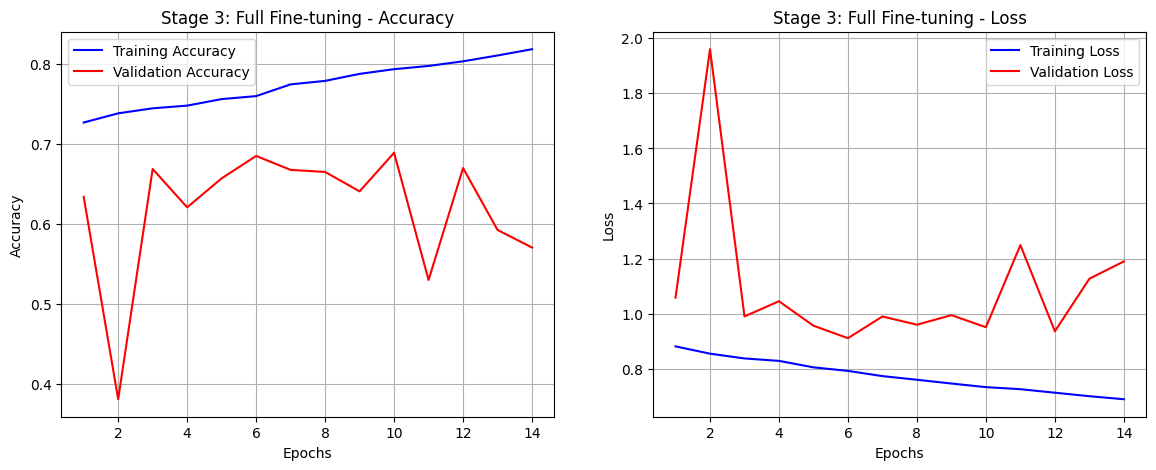

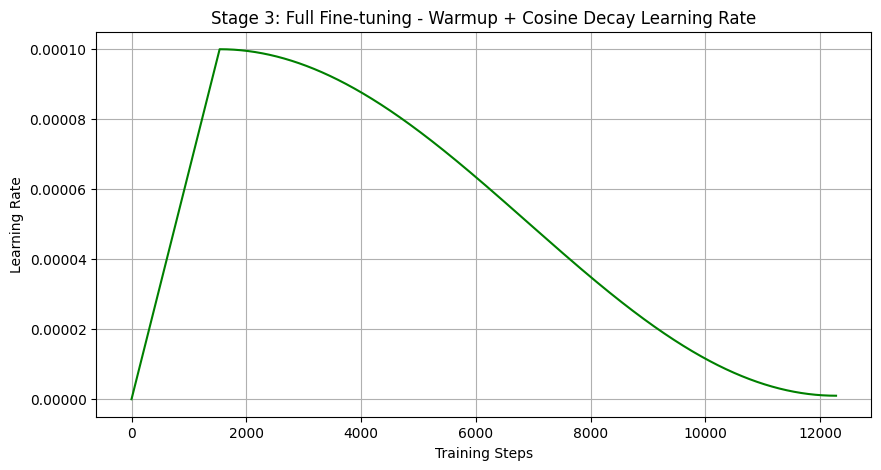

In [ ]:
# === Stage 3: Full Fine-Tuning VGG16 + Warmup Cosine Decay (Fix) ===
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt

# === GPU & Mixed Precision ===
try:
    mixed_precision.set_global_policy("mixed_float16")
except:
    pass

# === Dataset ===
img_size = (224, 224)
batch_size = 64
train_dir = "/content/MMAFEDB_15K/train"
val_dir   = "/content/MMAFEDB_15K/valid"

from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size,
                                              batch_size=batch_size, class_mode='categorical')
val_gen   = val_datagen.flow_from_directory(val_dir, target_size=img_size,
                                            batch_size=batch_size, class_mode='categorical')

# === Load model dari Stage 2 ===
model = load_model("/content/vgg16_stage3_best.h5")

# Unfreeze semua layer
for layer in model.layers:
    layer.trainable = True

# === Warmup + Cosine Decay Scheduler ===
steps_per_epoch = len(train_gen)
warmup_epochs = 5
total_epochs  = 40
warmup_steps = warmup_epochs * steps_per_epoch
decay_steps = (total_epochs - warmup_epochs) * steps_per_epoch

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, decay_steps, min_lr=1e-5):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.min_lr = min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return tf.cond(
            step < self.warmup_steps,
            lambda: self.base_lr * (step / self.warmup_steps),
            lambda: (self.base_lr - self.min_lr) *
                    0.5 * (1 + tf.cos(np.pi * (step - self.warmup_steps) / self.decay_steps)) + self.min_lr
        )

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
            "min_lr": self.min_lr,
        }

lr_schedule = WarmUpCosine(base_lr=1e-4,
                           warmup_steps=warmup_steps,
                           decay_steps=decay_steps,
                           min_lr=1e-6)

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

# === Loss & Compile ===
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# === Callbacks ===
early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(
    "/content/vgg16_stage3_full_best.keras",  # simpan di format baru
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# === Training Stage 3 ===
print("🚀 Stage 3: Full Fine-tuning with WarmupCosineDecay")
hist3 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("✅ Training selesai. Model terbaik tersimpan di /content/vgg16_stage3_full_best.keras")

# === Plot Training History ===
def plot_history(history, stage="Stage 3"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{stage} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{stage} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# === Plot Learning Rate Schedule ===
def plot_lr_schedule(lr_schedule, steps, stage="Stage 3"):
    lrs = [lr_schedule(step).numpy() for step in range(steps)]
    plt.figure(figsize=(10,5))
    plt.plot(range(steps), lrs, 'g-')
    plt.title(f'{stage} - Warmup + Cosine Decay Learning Rate')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# === Panggil plotting ===
plot_history(hist3, stage="Stage 3: Full Fine-tuning")
plot_lr_schedule(lr_schedule, steps_per_epoch * total_epochs, stage="Stage 3: Full Fine-tuning")


Found 3511 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 425ms/step


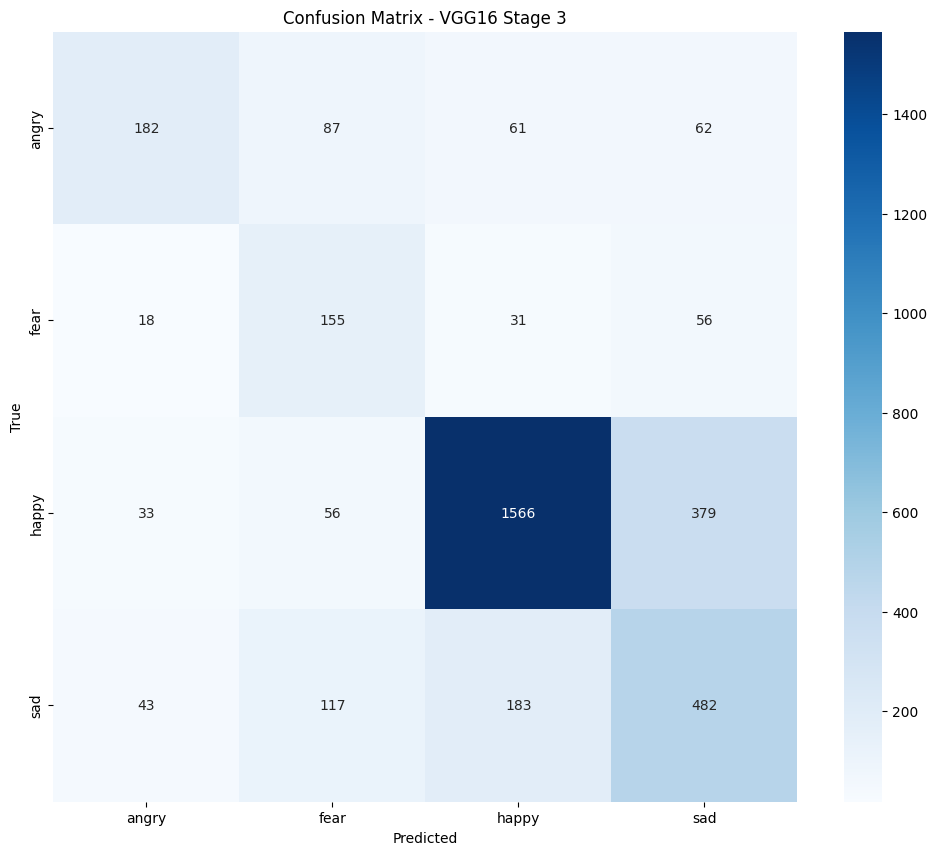

              precision    recall  f1-score   support

       angry       0.66      0.46      0.54       392
        fear       0.37      0.60      0.46       260
       happy       0.85      0.77      0.81      2034
         sad       0.49      0.58      0.53       825

    accuracy                           0.68      3511
   macro avg       0.59      0.60      0.59      3511
weighted avg       0.71      0.68      0.69      3511



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# === 1. Load Model dari .h5 ===
model = tf.keras.models.load_model("/content/vgg16_stage3_best.h5")

# === 2. Data test generator ===
img_size = (224,224)
batch_size = 64
test_dir = "/content/MMAFEDB_15K/test"

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(test_gen.class_indices.keys())

# === 3. Prediksi ===
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_gen.classes

# === 4. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VGG16 Stage 3")
plt.show()

# === 5. Classification Report ===
print(classification_report(y_true, y_pred, target_names=class_labels))


Saving sad.jpg to sad (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

=== Hasil Probabilitas ===
 angry: 0.22
  fear: 0.17
 happy: 0.26
   sad: 0.36

Prediksi utama: sad
Confidence: 0.36


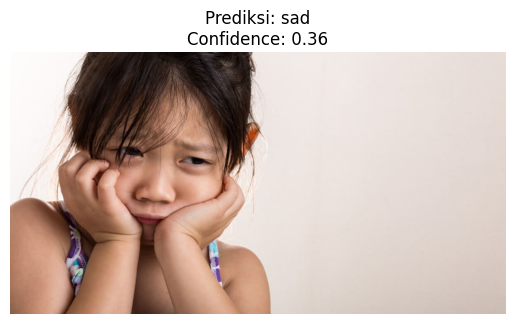

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Upload file gambar
uploaded = files.upload()

# Load model VGG16 hasil training kamu
model = tf.keras.models.load_model("/content/vgg16_stage3_best.h5")

# Daftar label sesuai urutan training (ubah sesuai dataset kamu)
class_labels = ["angry", "fear", "happy", "sad"]

def predict_emotion_verbose(model, img_path, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0   # normalisasi (VGG16 custom biasa pakai ini)

    prediction = model.predict(img_array)[0]

    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = np.max(prediction)

    # Print semua kelas
    print("\n=== Hasil Probabilitas ===")
    for label, prob in zip(class_labels, prediction):
        print(f"{label:>6}: {prob:.2f}")

    print("\nPrediksi utama:", predicted_class)
    print("Confidence:", f"{confidence:.2f}")

    # # Top-3 prediksi
    # top3_idx = prediction.argsort()[-3:][::-1]
    # print("\n--- Top-3 Prediksi ---")
    # for i in top3_idx:
    #     print(f"{class_labels[i]:>6}: {prediction[i]:.2f}")

    # Plot gambar + hasil
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Jalankan prediksi untuk semua file upload
for fn in uploaded.keys():
    predict_emotion_verbose(model, fn, class_labels)
